In [51]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [52]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [53]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [54]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412623,2013,1,regular,True,False,3878.0,2623,Missouri State,MVFC,fcs,17.0,NaN,2466,Northwestern State,Southland,fcs,23.0,NaN
4,332412230,2013,1,regular,True,True,3681.0,2230,Fordham,Patriot,fcs,51.0,NaN,227,Rhode Island,CAA,fcs,26.0,NaN


In [55]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [56]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Join and Filter the Data

In [57]:
# Merge games and plays data
cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

df = (
    df_games[cols].merge(df_plays, left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164


In [58]:
# Filter out overtime plays
df = df.query('period <= 4')

# Game must be completed
df = df.query('completed == True')

In [59]:
df.isna().sum()

game_id                    0
drive_id                   0
play_id                    0
drive_number               0
play_number                0
season                     0
week                       0
season_type                0
completed                  0
neutral_site               0
venue_id                7068
home_team                  0
home_id                    0
home_points                0
away_team                  0
away_id                    0
away_points                0
offense                    0
offense_conference      4587
offense_score              0
defense                    0
home                       0
away                       0
defense_conference      4834
defense_score              0
period                     0
offense_timeouts           0
defense_timeouts           0
yardline                   0
yards_to_goal              0
down                       0
distance                   0
yards_gained               0
scoring                    0
play_type     

## 3. Feature Engineering

In [60]:
df = df.assign(
    pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
    score_diff = df['offense_score'] - df['defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
    pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
    pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
    pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
    offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
    score_diff_final = np.where(df['offense'] == df['home'], df['home_points'] - df['away_points'], df['away_points'] - df['home_points'])
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,pct_game_played,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164,0.626389,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs,7.0
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164,0.626389,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs,7.0
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164,0.626389,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs,7.0
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164,0.677500,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs,7.0
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164,0.677500,-3,1,401.251954,1954.443118,1553.191164,fbs,fcs,7.0


In [61]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number',
       'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_team', 'home_id', 'home_points', 'away_team',
       'away_id', 'away_points', 'offense', 'offense_conference',
       'offense_score', 'defense', 'home', 'away', 'defense_conference',
       'defense_score', 'period', 'offense_timeouts', 'defense_timeouts',
       'yardline', 'yards_to_goal', 'down', 'distance', 'yards_gained',
       'scoring', 'play_type', 'play_text', 'ppa', 'clock_minutes',
       'clock_seconds', 'home_division', 'home_pregame_elo', 'away_division',
       'away_pregame_elo', 'pct_game_played', 'score_diff', 'is_home_team',
       'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo',
       'offense_division', 'defense_division', 'score_diff_final'],
      dtype='object')

## 4. Final Data

In [62]:
cols = ['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type', 'venue_id', 
        'offense', 'offense_conference', 'offense_division', 
        'defense', 'defense_conference', 'defense_division', 
        'score_diff', 'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo', 'pct_game_played',
        'offense_timeouts', 'defense_timeouts', 'is_home_team', 'yards_to_goal',
        'score_diff_final']

#TODO: remove filtering for FBS only?
df = df[cols].query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,score_diff_final
0,332412309,33241230914,332412309113,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0
1,332412309,33241230914,332412309115,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,45,7.0
2,332412309,33241230914,332412309112,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0
3,332412309,33241230914,332412309117,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,45,7.0
4,332412309,33241230914,332412309118,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,36,7.0


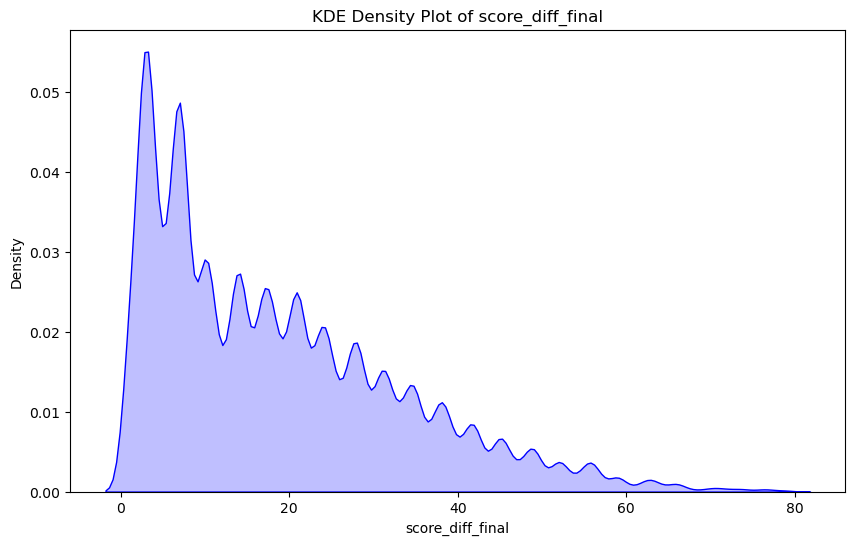

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('score_diff_final >= 0').score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

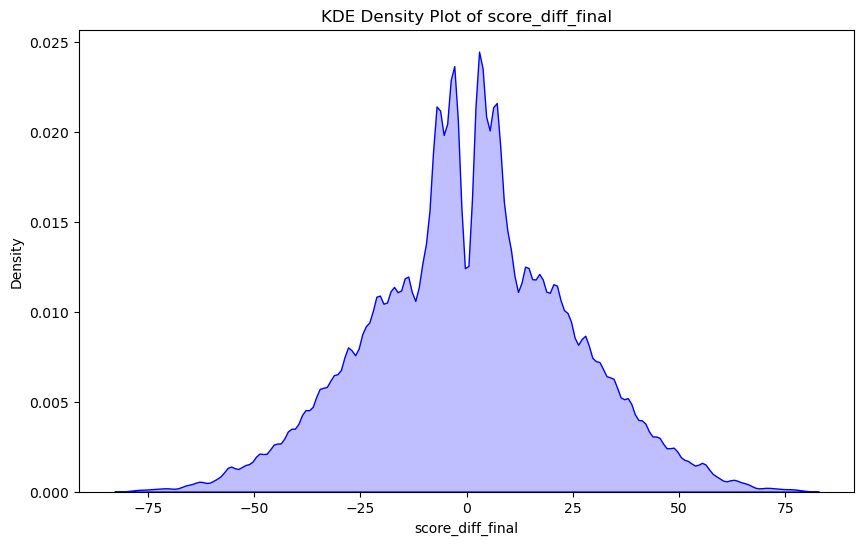

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

In [65]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,score_diff_final
0,332412309,33241230914,332412309113,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0
1,332412309,33241230914,332412309115,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,45,7.0
2,332412309,33241230914,332412309112,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0
3,332412309,33241230914,332412309117,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,45,7.0
4,332412309,33241230914,332412309118,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,36,7.0


In [66]:
df['won'] = np.where(df['score_diff_final'] > 0, 1, 0)

## 5. Make the model

In [ ]:
data = df[['game_id','drive_id','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
           'offense_timeouts','defense_timeouts','yards_to_goal',
           'won']]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)].drop(columns=['drive_id'])

In [68]:
data.head()

,game_id,drive_id,score_diff,pregame_elo_diff,pct_game_played,is_home_team,offense_timeouts,defense_timeouts,yards_to_goal,won
0,332412309,33241230914,-3,401.251954,0.626389,1,3.0,2.0,51,1
1,332412309,33241230914,-3,401.251954,0.626389,1,3.0,2.0,45,1
2,332412309,33241230914,-3,401.251954,0.626389,1,3.0,2.0,51,1
3,332412309,33241230914,-3,401.251954,0.677500,1,2.0,2.0,45,1
4,332412309,33241230914,-3,401.251954,0.677500,1,2.0,2.0,36,1


In [71]:
# model_dir = os.path.join(DATA_DIR, 'models', 'win_probability')

# model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

# models = []
# for model_file in model_files:
#     model_path = os.path.join(model_dir, model_file)
#     model = xgb.Booster()  # Create an empty Booster object
#     model.load_model(model_path)  # Load the model from the json file
#     models.append(model)

# print(f"Loaded {len(models)} models from the '{model_dir}' folder.")

In [75]:
data.isna().sum()

game_id             0
drive_id            0
score_diff          0
pregame_elo_diff    0
pct_game_played     0
is_home_team        0
offense_timeouts    0
defense_timeouts    0
yards_to_goal       0
won                 0
dtype: int64

In [76]:
data.dtypes

game_id               int64
drive_id             object
score_diff            int64
pregame_elo_diff    float64
pct_game_played     float64
is_home_team          int64
offense_timeouts    float64
defense_timeouts    float64
yards_to_goal         int64
won                   int64
dtype: object

In [77]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

N_BOOTSTRAP = 100
    
feature_names = data_train.drop(columns=['game_id','drive_id','won']).columns.tolist()
monotonic_constraints_map = {
    "score_diff": 1,
    "pregame_elo_diff": 1,
    "is_home_team": 1,
    "yards_to_goal": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Bootstrapping
models = []
for i in tqdm(range(N_BOOTSTRAP), desc='Bootstrapping'):
    # Bootstrap sampling
    game_ids = data_train.game_id.unique()
    game_ids_sample = np.random.choice(game_ids, size=len(data_train), replace=True)
    train_data = data_train[data_train.game_id.isin(game_ids_sample)]

    # Only keep one play per drive
    train_data = train_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
    train_data = train_data.drop_duplicates(subset=['game_id', 'drive_id'], keep='first')

    # Split into 80-20 train-val set by game_id
    game_ids_train, game_ids_valid = train_test_split(train_data.game_id.unique(), test_size=0.2, random_state=SEED)
    train = train_data[train_data.game_id.isin(game_ids_train)]
    valid = train_data[train_data.game_id.isin(game_ids_valid)]
    train_x = train.drop(columns=['game_id', 'drive_id', 'won'])
    train_y = train['won']
    valid_x = valid.drop(columns=['game_id', 'drive_id', 'won'])
    valid_y = valid['won']
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(
        study_name="win_probability_hyperopt", 
        direction="minimize", 
        load_if_exists=True
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

    # Train a model with the best params
    best_params = {
        **study.best_trial.params,
        'nthread': -1,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'logloss',
        'seed': SEED,
    }
    bst = xgb.train(
        best_params, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    models.append(bst)

Bootstrapping: 100%|██████████| 100/100 [1:38:06<00:00, 58.86s/it]


In [114]:
# all_shap_values = []

# background = data_train.drop(columns=['game_id', 'drive_id', 'won'])

# for model in tqdm(models[:10], desc='Calculating SHAP values'):
#     explainer = shap.TreeExplainer(model)
#     shap_vals = explainer.shap_values(background)
#     all_shap_values.append(shap_vals)

# shap_values_array = np.stack(all_shap_values)  # shape: (n_models, n_samples, n_features)
# mean_shap_values = np.mean(shap_values_array, axis=0)  # shape: (n_samples, n_features)

# shap.summary_plot(mean_shap_values, background)

Calculating Feature Importance: 100%|██████████| 100/100 [00:00<00:00, 2997.77it/s]


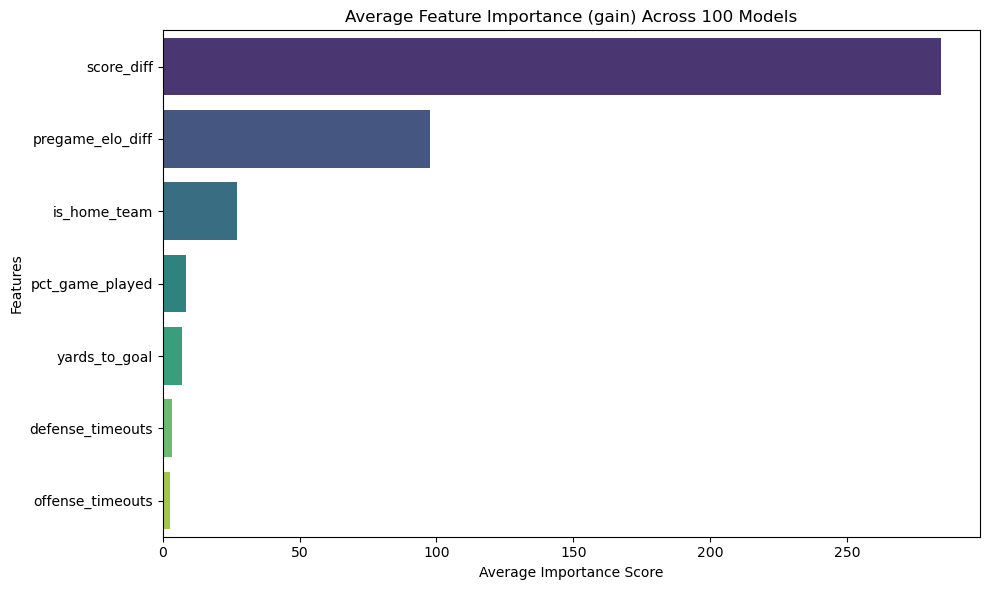

In [80]:
def plot_aggregated_feature_importance(models, importance_type="gain"):
    total_importance = {}

    # Aggregate importances across all models
    for model in tqdm(models, desc='Calculating Feature Importance'):
        importance = model.get_score(importance_type=importance_type)
        for feat, score in importance.items():
            total_importance[feat] = total_importance.get(feat, 0) + score

    # Average the importance by number of models
    for feat in total_importance:
        total_importance[feat] /= len(models)

    importance_df = pd.DataFrame({
        "Feature": list(total_importance.keys()),
        "Importance": list(total_importance.values())
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis", 
        hue="Feature", 
        dodge=False
    )
    plt.title(f"Average Feature Importance ({importance_type}) Across {len(models)} Models")
    plt.xlabel("Average Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

plot_aggregated_feature_importance(models, importance_type="gain") # gain, weight, cover

Average Test Log Loss over 100 models: 0.35783


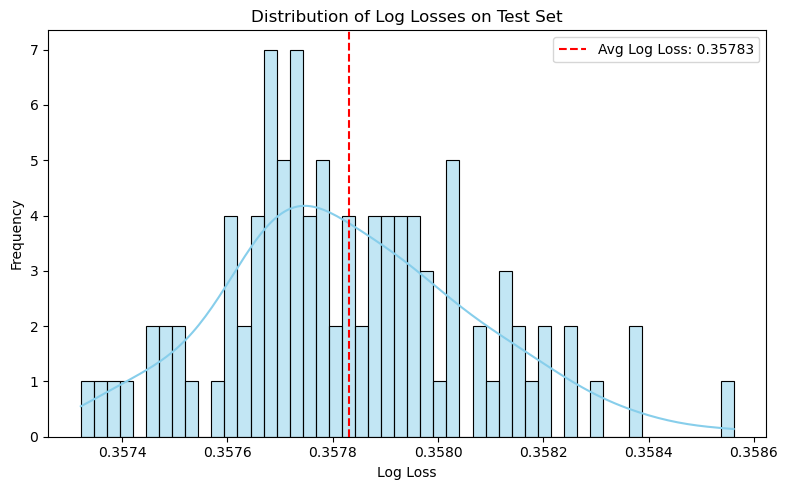

In [81]:
test_x = data_test.drop(columns=['game_id', 'won'])
test_y = data_test['won'].values.ravel()
dtest = xgb.DMatrix(test_x)

loglosses = []

for model in models:
    preds = model.predict(dtest)
    loss = log_loss(test_y, preds)
    loglosses.append(loss)

avg_logloss = np.mean(loglosses)
print(f"Average Test Log Loss over {len(models)} models: {avg_logloss:.5f}")

plt.figure(figsize=(8, 5))
sns.histplot(loglosses, bins=50, kde=True, color="skyblue")
plt.axvline(avg_logloss, color="red", linestyle="--", label=f"Avg Log Loss: {avg_logloss:.5f}")
plt.title("Distribution of Log Losses on Test Set")
plt.xlabel("Log Loss")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
data_all = data.drop(columns=['game_id', 'drive_id', 'won'])
dall = xgb.DMatrix(data_all)

preds_all_models = []

for model in models:
    preds = model.predict(dall)
    preds_all_models.append(preds)

preds_all_models = np.array(preds_all_models)

# Calculate the 5%, 50%, 95% percentiles and the mean for each sample
df['win_proba_5'] = np.percentile(preds_all_models, 5, axis=0)
df['win_proba_50'] = np.percentile(preds_all_models, 50, axis=0)
df['win_proba_95'] = np.percentile(preds_all_models, 95, axis=0)
df['win_proba_mean'] = np.mean(preds_all_models, axis=0)

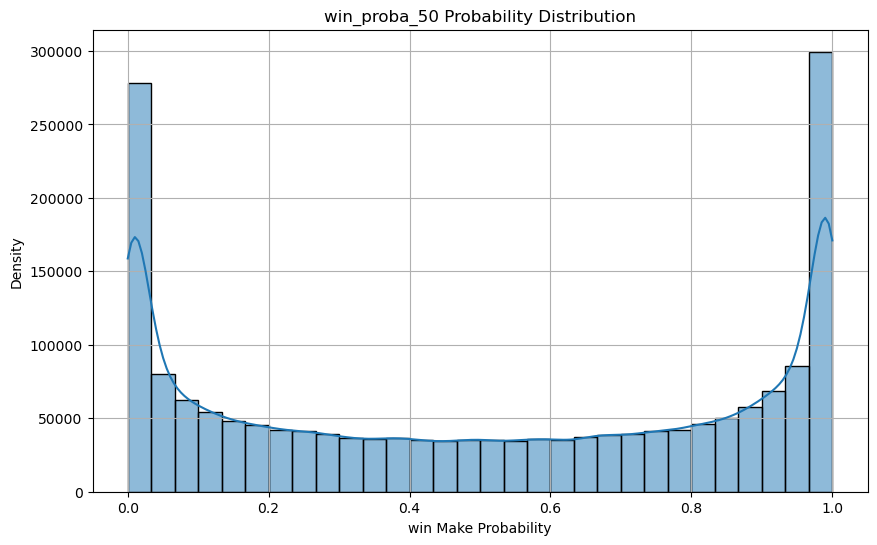

In [ ]:
# plot win probability
def plot_wp(df, col='win_proba_50'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('
    n Make Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='win_proba_50')

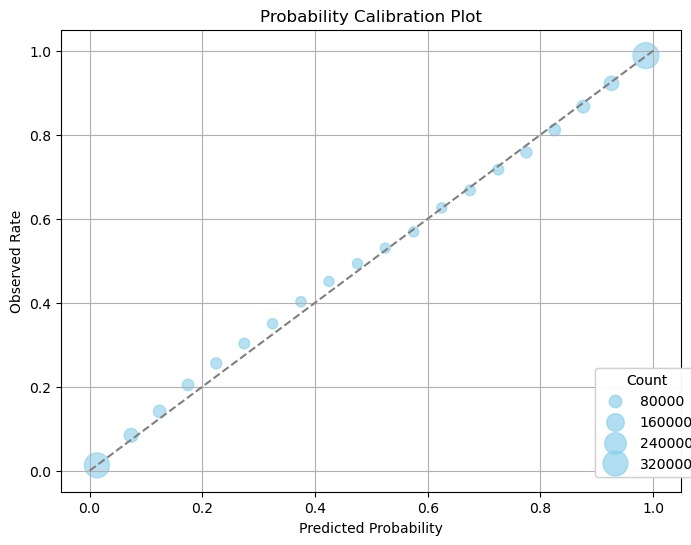

In [84]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='win_proba_50', actual_col='won', bins=20, scale=0.001)

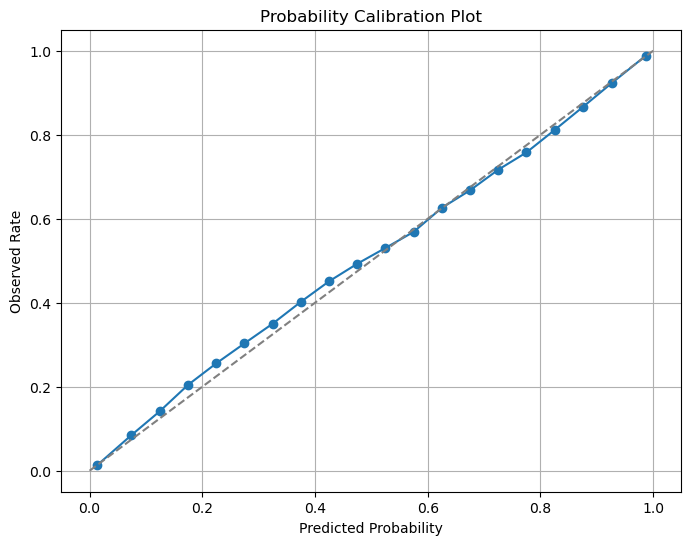

In [85]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='win_proba_50', actual_col='won', bins=20)

In [86]:
df[data.columns.tolist() + ['win_proba_5','win_proba_50','win_proba_95']].sort_values(by='win_proba_50', ascending=True).head(10)

,game_id,drive_id,score_diff,pregame_elo_diff,pct_game_played,is_home_team,offense_timeouts,defense_timeouts,yards_to_goal,won,win_proba_5,win_proba_50,win_proba_95
1568376,401524013,40152401324,-43,-1676.919750,1.000000,-1,0.0,1.0,79,0,0.000003,0.000018,0.000074
1568377,401524013,40152401324,-43,-1676.919750,1.000000,-1,0.0,1.0,71,0,0.000005,0.000021,0.000077
1568375,401524013,40152401324,-43,-1676.919750,0.986667,-1,0.0,1.0,90,0,0.000006,0.000022,0.000082
1052333,401110841,40111084125,-31,-1450.759820,0.993333,-1,0.0,2.0,74,0,0.000006,0.000023,0.000068
1052334,401110841,40111084125,-31,-1450.759820,0.993333,-1,0.0,2.0,74,0,0.000006,0.000023,0.000068
159645,400548255,40054825527,-31,-1673.651959,0.997222,-1,1.0,3.0,80,0,0.000007,0.000024,0.000090
239341,400548363,40054836326,-31,-1599.578230,0.995000,-1,1.0,3.0,85,0,0.000008,0.000025,0.000082
324070,400787112,40078711235,-52,-1937.979222,0.999444,0,0.0,2.0,75,0,0.000006,0.000025,0.000079
1052332,401110841,40111084125,-31,-1450.759820,0.993333,-1,0.0,2.0,69,0,0.000007,0.000026,0.000071
607232,400869060,40086906023,-36,-1884.225337,0.979722,-1,0.0,3.0,70,0,0.000005,0.000026,0.000085


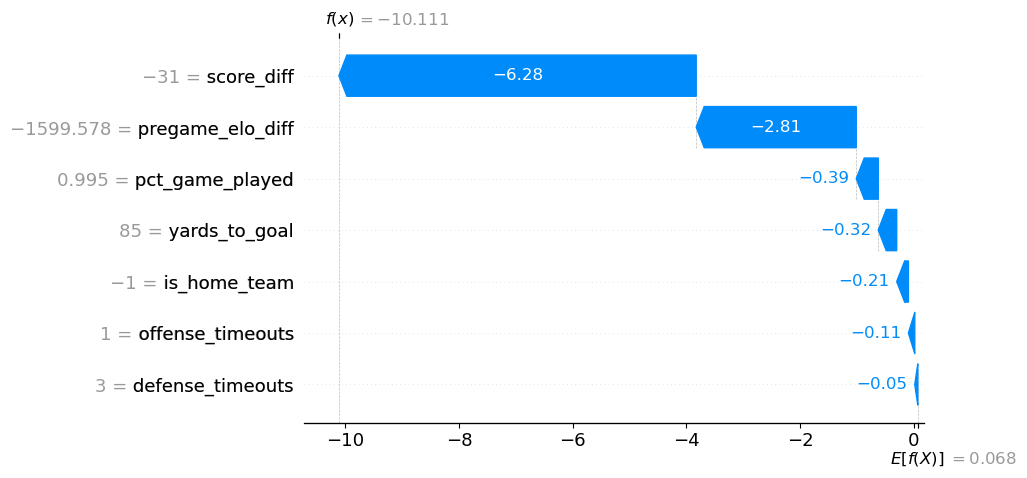

In [87]:
idx = 239341

model = models[0]

game_data = data[data.index == idx].drop(columns=['game_id', 'drive_id', 'won']).head(1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [107]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,score_diff_final,won,win_proba_5,win_proba_50,win_proba_95,win_proba_mean,proba_bin
0,332412309,33241230914,332412309113,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0,1,0.642427,0.667536,0.699383,0.668367,13
1,332412309,33241230914,332412309115,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,45,7.0,1,0.663968,0.683908,0.714962,0.684904,13
2,332412309,33241230914,332412309112,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,7.0,1,0.642427,0.667536,0.699383,0.668367,13
3,332412309,33241230914,332412309117,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,45,7.0,1,0.610085,0.632389,0.663787,0.635163,12
4,332412309,33241230914,332412309118,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,36,7.0,1,0.613639,0.636520,0.666141,0.638547,12


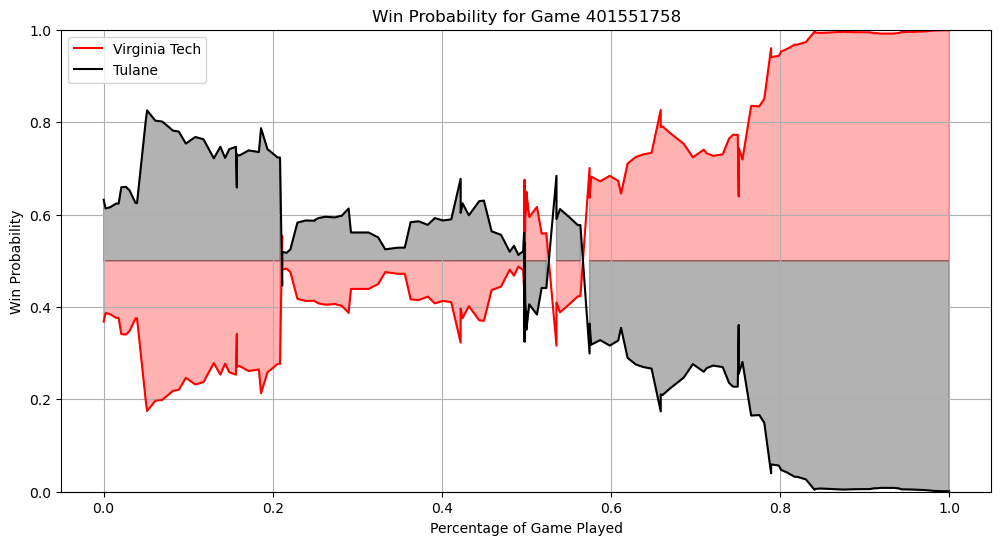

In [112]:
def plot_wp_game(df, game_id):
    cols = ['game_id', 'drive_id', 'play_id', 'pct_game_played', 'offense', 'win_proba_50', 'score_diff']
    game = (
        df.query('game_id == @game_id')
        .sort_values(['pct_game_played','play_id'], ascending=[True, True])
        [cols]
    )
    teams = game.offense.unique()
    t1, t2 = game.copy(), game.copy()
    t1['win_proba_50'] = np.where(t1['offense'] == teams[0], t1['win_proba_50'], 1 - t1['win_proba_50'])
    t2['win_proba_50'] = np.where(t2['offense'] == teams[1], t2['win_proba_50'], 1 - t2['win_proba_50'])

    plt.figure(figsize=(12, 6))
    plt.plot(t1['pct_game_played'], t1['win_proba_50'], label=teams[0], color='red')
    plt.fill_between(t1['pct_game_played'], t1['win_proba_50'], 0.5, where=(t1['win_proba_50'] >= 0.5), color='red', alpha=0.3)
    plt.fill_between(t1['pct_game_played'], t1['win_proba_50'], 0.5, where=(t1['win_proba_50'] < 0.5), color='red', alpha=0.3)

    plt.plot(t2['pct_game_played'], t2['win_proba_50'], label=teams[1], color='black')
    plt.fill_between(t2['pct_game_played'], t2['win_proba_50'], 0.5, where=(t2['win_proba_50'] >= 0.5), color='black', alpha=0.3)
    plt.fill_between(t2['pct_game_played'], t2['win_proba_50'], 0.5, where=(t2['win_proba_50'] < 0.5), color='black', alpha=0.3)

    plt.title(f'Win Probability for Game {game_id}')
    plt.xlabel('Percentage of Game Played')
    plt.ylabel('Win Probability')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()

plot_wp_game(df, 401551758)

In [113]:
model_dir = join(DATA_DIR, 'models', 'win_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i, model in enumerate(models):
    model_path = os.path.join(model_dir, f"model_{i}.json")
    model.save_model(model_path)

print(f"Saved {len(models)} models to the '{model_dir}' folder.")

Saved 100 models to the '../data/models/win_probability' folder.
